# Bootstrapping with 1-D harmonic potential

In this code, we demonstrate 1-dimensional harmonic potential with $\hbar = 1$ and $m = 1$. We begin with

\begin{align*}
    H &= \frac{P^2}{2m}+V(x)\\
    V(x) &= kx^2\\
    [X,P] &= i
\end{align*}

Since for any operator $O$, we have $\langle E|[H, O]|E\rangle=0$, consider $O_1=X^{s}P$ and $O_2=X^{s-1}$
\begin{align*}
    [H, O_1] = [H, X^{s}P] &= 0 = 
    -\frac{1}{2}s(s-1)\langle X^{s-2}P\rangle 
    -is\langle X^{s-1}P^2\rangle+
    i\langle X^{s}V^\prime(x)\rangle\\
    
    [H, O_2] = [H, X^{s-1}] &= 0 =
    -\frac{1}{2}(s-1)(s-2)\langle X^{s-3}\rangle
    -i(s-1)\langle X^{s-2}P\rangle
\end{align*}

Conbine these two equations, we can get
\begin{equation*}
    0 = \frac{1}{4}s(s-1)(s-2)\langle X^{s-3}\rangle
    +s\langle X^{s-1}P^2\rangle
    -\langle X^sV^\prime (x)\rangle
\end{equation*}

Now consider $\langle E|X^{s-1}H|E\rangle$
\begin{align*}
    \langle E|X^{s-1}H|E\rangle & = E\langle X^{s-1}\rangle \\
    \langle E|X^{s-1}H|E\rangle & = \frac{1}{2}\langle X^{s-1}P^2\rangle + \langle X^{s-1}V(x)\rangle \\
\end{align*}

So we have $\langle X^{s-1}P^2\rangle = 2E\langle X^{s-1}\rangle - 2\langle X^{s-1}V(x)\rangle$, substitute into the equation above and finally we get
\begin{equation*}
    0 = 2sE\langle X^{s-1}\rangle + \frac{1}{4}s(s-1)(s-2)\langle X^{s-3}\rangle 
    - \langle X^s V^\prime (x)\rangle - 2s\langle X^{s-1}V(x)\rangle
\end{equation*}

In [1]:
import os, time
import numpy as np
import sympy as sp
from bootstrap_sympy import sympy_solve_intervals, plot_energy_interval

import matplotlib.pyplot as plt
import seaborn as sns

## Recursion relation for 1-d harmonic potential

Plug in $V(x)=kx^2$ into the recursion relation, we get

\begin{equation*}
    \langle X^{s}\rangle \ =\  \frac{(s-1)E}{ks}\langle X^{s-2}\rangle + \frac{(s-1)(s-2)(s-3)}{8ks}\langle X^{s-4}\rangle
\end{equation*}

With $\langle X^0\rangle=1$ by normalization, and $\langle X^1\rangle=0$ by symmetry. Also, take $s=2$ we get $\langle X^2\rangle=\frac{E}{2k}$

In [2]:
class HarmonicPotentialMatrix:
    def __init__(self, N):
        self.N = N # maximum size of submatrix
        self.k = sp.symbols('k') # constant of harmonic potential
        self.E = sp.symbols('E') # eigen-energy to be solved
    
    def evaluate(self):
        '''
            - If assign the value of other paramters (i.e., k) first, it will give the matrix element list with only E
            - Otherwise it will represented ohter parameters with symbols
        '''
        self.Xs_list = [] # list of X^s, the expectation value of position operator X to the s power
        for i in range(2*(self.N-1)+1):
            if i >= 4:
                self.Xs_list.append(self.Xs_recursion(s=i, Xs_2=self.Xs_list[i-2], Xs_4=self.Xs_list[i-4]))
            else:
                self.Xs_list.append(self.Xs_recursion(s=i))

    def Xs_recursion(self, s, Xs_2=None, Xs_4=None):
        '''
            Find the <X^s> with recursion relation
        '''
        if s == 0:
            return 1
        elif s == 2:
            return self.E * sp.Rational(1,2) / self.k
        elif s%2 != 0:
            return 0
        else:
            if Xs_2 == None or Xs_4 == None:
                Xs_2 = self.Xs_recursion(s-2)
                Xs_4 = self.Xs_recursion(s-4)
            result  = self.E * sp.Rational((s-1),s) / self.k * Xs_2
            result += sp.Rational((s-1)*(s-2)*(s-3),8*s) / self.k * Xs_4
            return sp.simplify(result)

    def submatrix(self, K):
        '''
            K by K matrix's [i,j] element = <X^(i+j)>
        '''
        return sp.Matrix([[self.Xs_list[i+j] for j in range(K)] for i in range(K)])

## Set hyperparameters

We set hyperparameters in the `config` dictionary. Here is some following instructions of the function `matrix.evaluate()`:
- If you want to see the expression of matrix elements and determinants with other explicit parameters (i.e., $k$), please evaluate the matrix before assigning numerical values, or just simply remove lines `matrix.k = ...`  , .etc.
- On the other hand, to accelerate the computation, please assign the numerical values (except $E$) before `matrix.evaluate()`

In [3]:
# saving paths
save_dir = os.path.abspath('harmonic')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

hp_config = {
    'round' : 30, # maximum size of submatrix to compute the determinant
    'threshold' : 1e-2, # threshold to keep small intervals
    'initial_interval' : sp.Interval(0, sp.oo), # expected region for energy
}

hp_matrix = HarmonicPotentialMatrix(N=hp_config['round'])
hp_matrix.k = 1

k = hp_matrix.k
hp_config['npy_energy_intervals'] = os.path.join(save_dir, f"energy_intervals_k{sp.N(k):.2f}.npy")
hp_config['npy_confirmed_intervals'] = os.path.join(save_dir, f"confirmed_intervals_k{sp.N(k):.2f}.npy")

hp_matrix.evaluate()
energy_intervals, confirmed_intervals = sympy_solve_intervals(hp_matrix, hp_config, mode='Poly', keep=False)

Checkpoint exists, checkpoint max K=30



## Theoretic energy eigenvalues

The hamiltonian is $H=\frac{P^2}{2}+kx^2$. Recall for 1-D simple harmonic potential, the hamiltonian is $H_{hp}=\frac{P^2}{2m}+\frac{1}{2}m\omega^2x^2$, with energy eigenvalues $E^\omega_n=\hbar\omega(n+\frac{1}{2})$. So the energy eigenvalues for $H$ is $E^k_n=\hbar\sqrt{2k}(n+\frac{1}{2})$

Confirmed intervals = Union(Interval(0.702374632153415, 0.708997306999531), Interval(2.11792872729371, 2.12309791083538), Interval(3.53320749261362, 3.53966474801339), Interval(4.94546138035332, 4.95205141425372), Interval(6.36209265479725, 6.36821653763948))


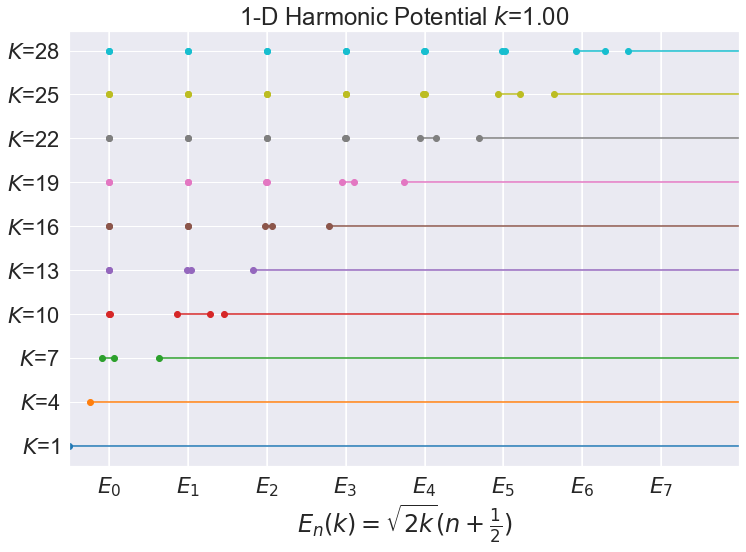

In [4]:
if confirmed_intervals != None:
    print(f"Confirmed intervals = {sp.N(confirmed_intervals)}")

hp_config['plot_step'] = 3 # how often to plot the result
hp_config['x_inf'] = 0 # infimum for x-axis when plotting
hp_config['x_sup'] = 12 # supremum for x-axis when plotting


energy_eigenvalues = [(2*k)**0.5 * (n+0.5) for n in range(hp_config['round'])]
x_ticks = [r"$E_{{{}}}$".format(i) for i in range(len(energy_eigenvalues))]

np.save(hp_config['npy_energy_intervals'], energy_intervals, allow_pickle=True)
np.save(hp_config['npy_confirmed_intervals'], confirmed_intervals, allow_pickle=True)

sns.set_style('dark')
sns.set(font_scale=2)
fig, ax = plot_energy_interval(energy_intervals, energy_eigenvalues, x_ticks, hp_config)
ax.set_title(f"1-D Harmonic Potential $k$={sp.N(k):.2f}")
ax.set_xlabel(r"$E_n(k) = \sqrt{2k}(n+\frac{1}{2})$")
plt.savefig(os.path.join(save_dir, f"result_N{hp_config['round']}_k{sp.N(k):.2f}.png"))